In [29]:
import carla
import time
import cv2
import numpy as np
import pygame
from collections import deque
import random
import torch
from scipy.spatial import cKDTree
import pickle
import torch
from torch.utils.data import Sampler, DataLoader
from utils import Logger, load_pretrain, gpu
from Net import Net


def get_traffic_light(vehicle_location):
    # 检查交通灯状态
    traffic_flag, traffic_state = 0, -1

    traffic_light = world.get_traffic_lights_from_waypoint(world.get_map().get_waypoint(vehicle_location), 20)
    if len(traffic_light) > 0:
        traffic_flag = 1
        traffic = traffic_light[0].get_state()
        if traffic == carla.TrafficLightState.Red:
            traffic_state = 0
        elif traffic == carla.TrafficLightState.Yellow:
            traffic_state = 1
        elif traffic == carla.TrafficLightState.Green:
            traffic_state = 2
    else:
        traffic_state = -1
    return traffic_flag, traffic_state 


def update_vehicle_trajectories(target_vehicle, history_trajectory, surrounding_vehicles_queues, detection_radius=20):
    target_location = target_vehicle.get_location()
    traffic_flag, traffic_state = get_traffic_light(target_location)
    history_trajectory.append((target_location.x, target_location.y, 1, traffic_flag, traffic_state))

    vehicles = world.get_actors().filter('vehicle.*')
    active_vehicle_ids = []  # 存储在20米范围内的车辆ID
    for vehicle in vehicles:
        vehicle_location = vehicle.get_location()
        traffic_flag, traffic_state = get_traffic_light(vehicle_location)
        if vehicle.id != target_vehicle.id and vehicle_location.distance(target_location) < detection_radius:
            if vehicle.id not in surrounding_vehicles_queues:
                surrounding_vehicles_queues[vehicle.id] = deque(maxlen=20)
            surrounding_vehicles_queues[vehicle.id].append((vehicle_location.x, vehicle_location.y, 1, traffic_flag, traffic_state))
            active_vehicle_ids.append(vehicle.id)
    
    # 删除不再活跃的车辆记录
    for vehicle_id in list(surrounding_vehicles_queues):
        if vehicle_id not in active_vehicle_ids:
            del surrounding_vehicles_queues[vehicle_id]


def create_trajectory_tensor(history_trajectory, surrounding_vehicles_queues):
    trajectories = []
    # 添加目标车辆的轨迹
    target_traj = list(history_trajectory)
    target_traj += [target_traj[-1]] * (20 - len(target_traj))
    trajectories.append(target_traj)

    # 添加周围车辆的轨迹
    for vehicle_id, queue in surrounding_vehicles_queues.items():
        vehicle_traj = list(queue)
        vehicle_traj += [vehicle_traj[-1]] * (20 - len(vehicle_traj))
        trajectories.append(vehicle_traj)

    # 转换为tensor
    trajectories_tensor = torch.tensor(trajectories, dtype=torch.float32)
    return trajectories_tensor


def get_nearby_waypoints(target_vehicle, waypoints_xy, radius=30.0):
    target_location = target_vehicle.get_location()
    indices = tree.query_ball_point([target_location.x, target_location.y], radius)
    nearby_waypoints = [waypoints_xy[i] for i in indices]
    nearby_waypoints_np = np.array(nearby_waypoints)
    nearby_waypoints_tensor = torch.from_numpy(nearby_waypoints_np).float()
    return nearby_waypoints_tensor


def draw_predicted_trajectories(traj_pred, world, target_vehicle):
    # 定义三种不同的颜色
    colors = [carla.Color(r=255, g=0, b=0),   # 红色
              carla.Color(r=0, g=255, b=0),   # 绿色
              carla.Color(r=0, g=0, b=255)]   # 蓝色

    # 检查轨迹维度是否正确
    if traj_pred.shape[0] != 3 or traj_pred.shape[2] != 2:
        raise ValueError("预测轨迹的形状应为 (3, N, 2)")

    # 循环绘制每条轨迹的每个点
    for i in range(3):  # 对于每条轨迹
        for point in traj_pred[i]:
            # 将轨迹点从numpy数组转换为CARLA的Location对象
            location = carla.Location(x=float(point[0]), y=float(point[1]), z = target_vehicle.get_location().z + 1.5)
            # 绘制点
            world.debug.draw_point(location, 0.1, colors[i], 100)


def spawn_vehicles(world, vehicle_count=50):
    vehicles = []
    spawn_points = world.get_map().get_spawn_points()
    vehicle_blueprints = world.get_blueprint_library().filter('*vehicle*')
    for _ in range(vehicle_count):
        blueprint = random.choice(vehicle_blueprints)
        spawn_point = random.choice(spawn_points)
        vehicle = world.try_spawn_actor(blueprint, spawn_point)
        if vehicle is not None:
            vehicle.set_autopilot(True)
            vehicles.append(vehicle)
    return vehicles


def spawn_target_vehicle(world):
    target_vehicle_bp = world.get_blueprint_library().filter('model3')[0]
    spawn_point = carla.Transform(carla.Location(x=40, y=0, z=3), carla.Rotation(yaw=180))
    target_vehicle = world.spawn_actor(target_vehicle_bp, spawn_point)
    target_vehicle.set_autopilot(True)
    return target_vehicle



# 初始化Pygame和Carla
# pygame.init()
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.load_world('Town05')

spectator = world.get_spectator()




# 加载地图
waypoints_xy = np.array(pickle.load(open('./waypoints_xy.pkl', 'rb')))
tree = cKDTree(waypoints_xy)


# 初始化轨迹预测网络
net = Net().cuda()
ckpt_path = './traffic_1_net40.000.ckpt'
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()

# 生成车辆
vehicles = spawn_vehicles(world)  
target_vehicle = spawn_target_vehicle(world) # 生成目标车辆
vehicles.append(target_vehicle)

# 初始化目标车辆的历史轨迹队列和周围车辆队列
history_trajectories = {}
surrounding_vehicles_queues = {}

start_time = time.time()
start_time2 = time.time()

In [2]:
if time.time() - start_time > 1:
    start_time = time.time()
    world.debug.draw_point(target_vehicle.get_location(), 0.1, carla.Color(r=255, g=0, b=0), 100)

In [30]:
for vehicle in vehicles:
    if vehicle.get_location().distance(target_vehicle.get_location()) > 500 or vehicle.id == target_vehicle.id:
        continue

    pred_vehicle = vehicle
    if time.time() - start_time2 > 1:
        start_time2 = time.time()
        world.debug.draw_point(pred_vehicle.get_location(), 0.1, carla.Color(r=0, g=255, b=0), 100)
    if vehicle not in history_trajectories:
        history_trajectories[vehicle.id] = deque(maxlen=20)
        surrounding_vehicles_queues[vehicle.id] = {}

    # 更新轨迹信息
    update_vehicle_trajectories(pred_vehicle, history_trajectories[vehicle.id], surrounding_vehicles_queues[vehicle.id])
    trajectories_tensor = create_trajectory_tensor(history_trajectories[vehicle.id], surrounding_vehicles_queues[vehicle.id])
    trajectories_ctrs = trajectories_tensor.clone().detach()[:, -1, :2]
    nearby_waypoints = get_nearby_waypoints(pred_vehicle, waypoints_xy)

    # 构建网络输入
    data = dict()
    data['feat'] = [trajectories_tensor.cuda()]
    data['ctrs'] = [trajectories_ctrs.cuda()]
    data['nbr_waypoints'] = [nearby_waypoints.cuda()]

    # 预测轨迹并绘制
    print('predicting...')
    print(data['feat'][0].shape)
    output = net(data)
    traj_pred = output['reg'][0][0][:3].cpu().detach().numpy()   # shape = (3, 30, 2)
    draw_predicted_trajectories(traj_pred, world, pred_vehicle)



predicting...
torch.Size([3, 20, 5])
agt_idcs [tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169,

: 

In [28]:
 
location = carla.Location(x=0, y=0, z=1) 
color = carla.Color(r=255, g=0, b=0) 
lifetime = 60.0 
world.debug.draw_point(location, size=0.1, color=color, life_time=lifetime, persistent_lines=True)

In [46]:
data.keys()

dict_keys(['feat', 'ctrs', 'nbr_waypoints'])

In [11]:
data['feat'][0][0].shape

torch.Size([20, 5])

In [27]:
data['ctrs']

[tensor([[0., 0.],
         [0., 0.]], device='cuda:0')]

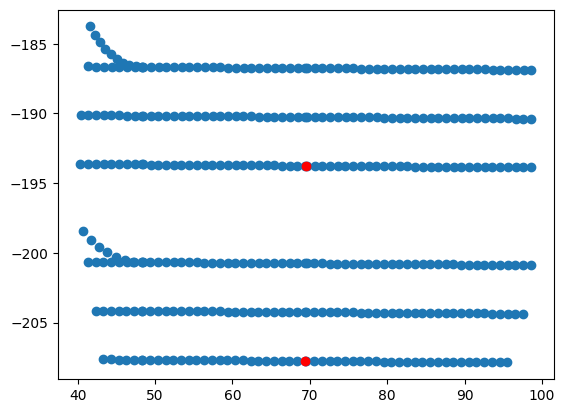

In [26]:
from matplotlib import pyplot as plt

for i in range(len(data['nbr_waypoints'])):
    way = data['nbr_waypoints'][0].cpu()
    plt.scatter(way[:, 0], way[:, 1])

for i in range(len(data['feat'][0])):
    v = data['feat'][0][i][0].cpu()
    plt.scatter(v[0], v[1], c='r')